# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest, GradientBoostingClassifier, StackingClassifier, RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder,OneHotEncoder, MinMaxScaler
from sklearn import linear_model 
from sklearn.linear_model import LogisticRegression
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.metrics import classification_report
import optuna

In [2]:
# Используемые функции
# функция по обработке выбросов по методу Тьюки
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, round(lower_bound),round(upper_bound)

def get_age_category(age):
    if age < 30:
        age_category = '<30'
    elif 30 <= age < 40:
        age_category = '30-40'
    elif 40 <= age < 50:
        age_category = '40-50'
    elif 50 <= age < 60:
        age_category = '50-60'
    else:
        age_category = '60+'
    return age_category

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [3]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [4]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df.job.unique().tolist()

['admin.',
 'technician',
 'services',
 'management',
 'retired',
 'blue-collar',
 'unemployed',
 'entrepreneur',
 'housemaid',
 'unknown',
 'self-employed',
 'student']

### Задание 3

In [6]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df_copy = df.copy()
df_copy['balance'] = df_copy['balance'].apply(lambda x: str(x).replace(',','.').replace('$','').replace(' ',''))
df_copy['balance'] = df_copy['balance'].astype('float')
df_copy['balance'].mean().round(3)

1529.129

### Задание 4

In [7]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
# ваш код

values = {
    'balance': df_copy['balance'].median()
}
#заполняем пропуски в соответствии с заявленным словарем
df_copy = df_copy.fillna(values)
df_copy['balance'].mean().round(3)

1526.936

### Задание 5

In [8]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
df_copy['job'].mode()

df_copy['job'] = np.where(df_copy['job']=='unknown', df_copy['job'].mode(),df_copy['job'])
df_copy['education'] = np.where(df_copy['education']=='unknown', df_copy['education'].mode(),df_copy['education'])


In [9]:
mask1 = df_copy['education']=="secondary"
mask2 = df_copy['job']=="management"

df_copy[mask1 & mask2]['balance'].mean().round(3)

1598.883

### Задание 6

In [10]:
# удалите все выбросы для признака balance
# ваш код
outliers, cleaned,lower_bound,upper_bound = outliers_iqr(df_copy, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
print(f'Нижняя граница: {lower_bound}')
print(f'Нижняя граница: {upper_bound}')



Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105
Нижняя граница: -2241
Нижняя граница: 4063


## Часть 2:  Разведывательный анализ

### Задание 1

deposit
no     5424
yes    4681
Name: count, dtype: int64

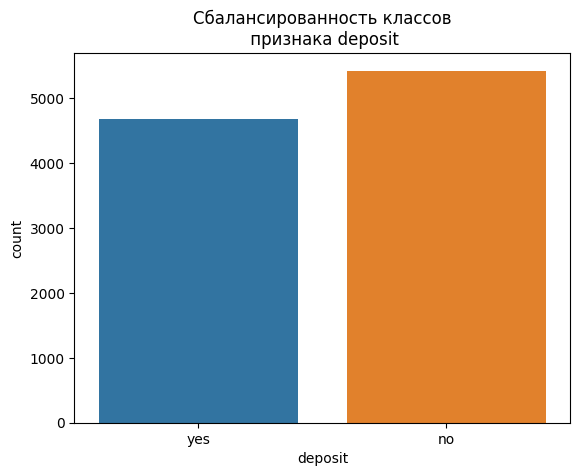

In [11]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# ваш код
display(cleaned.deposit.value_counts())
dep = sns.countplot(data=cleaned, x="deposit", hue='deposit');
dep.set_title('Сбалансированность классов\n признака deposit');

Можно сказать что классы в целевой переменной почти сбалансированы, но для точности моделирования я все же предпочту использовать параметр `stratify`

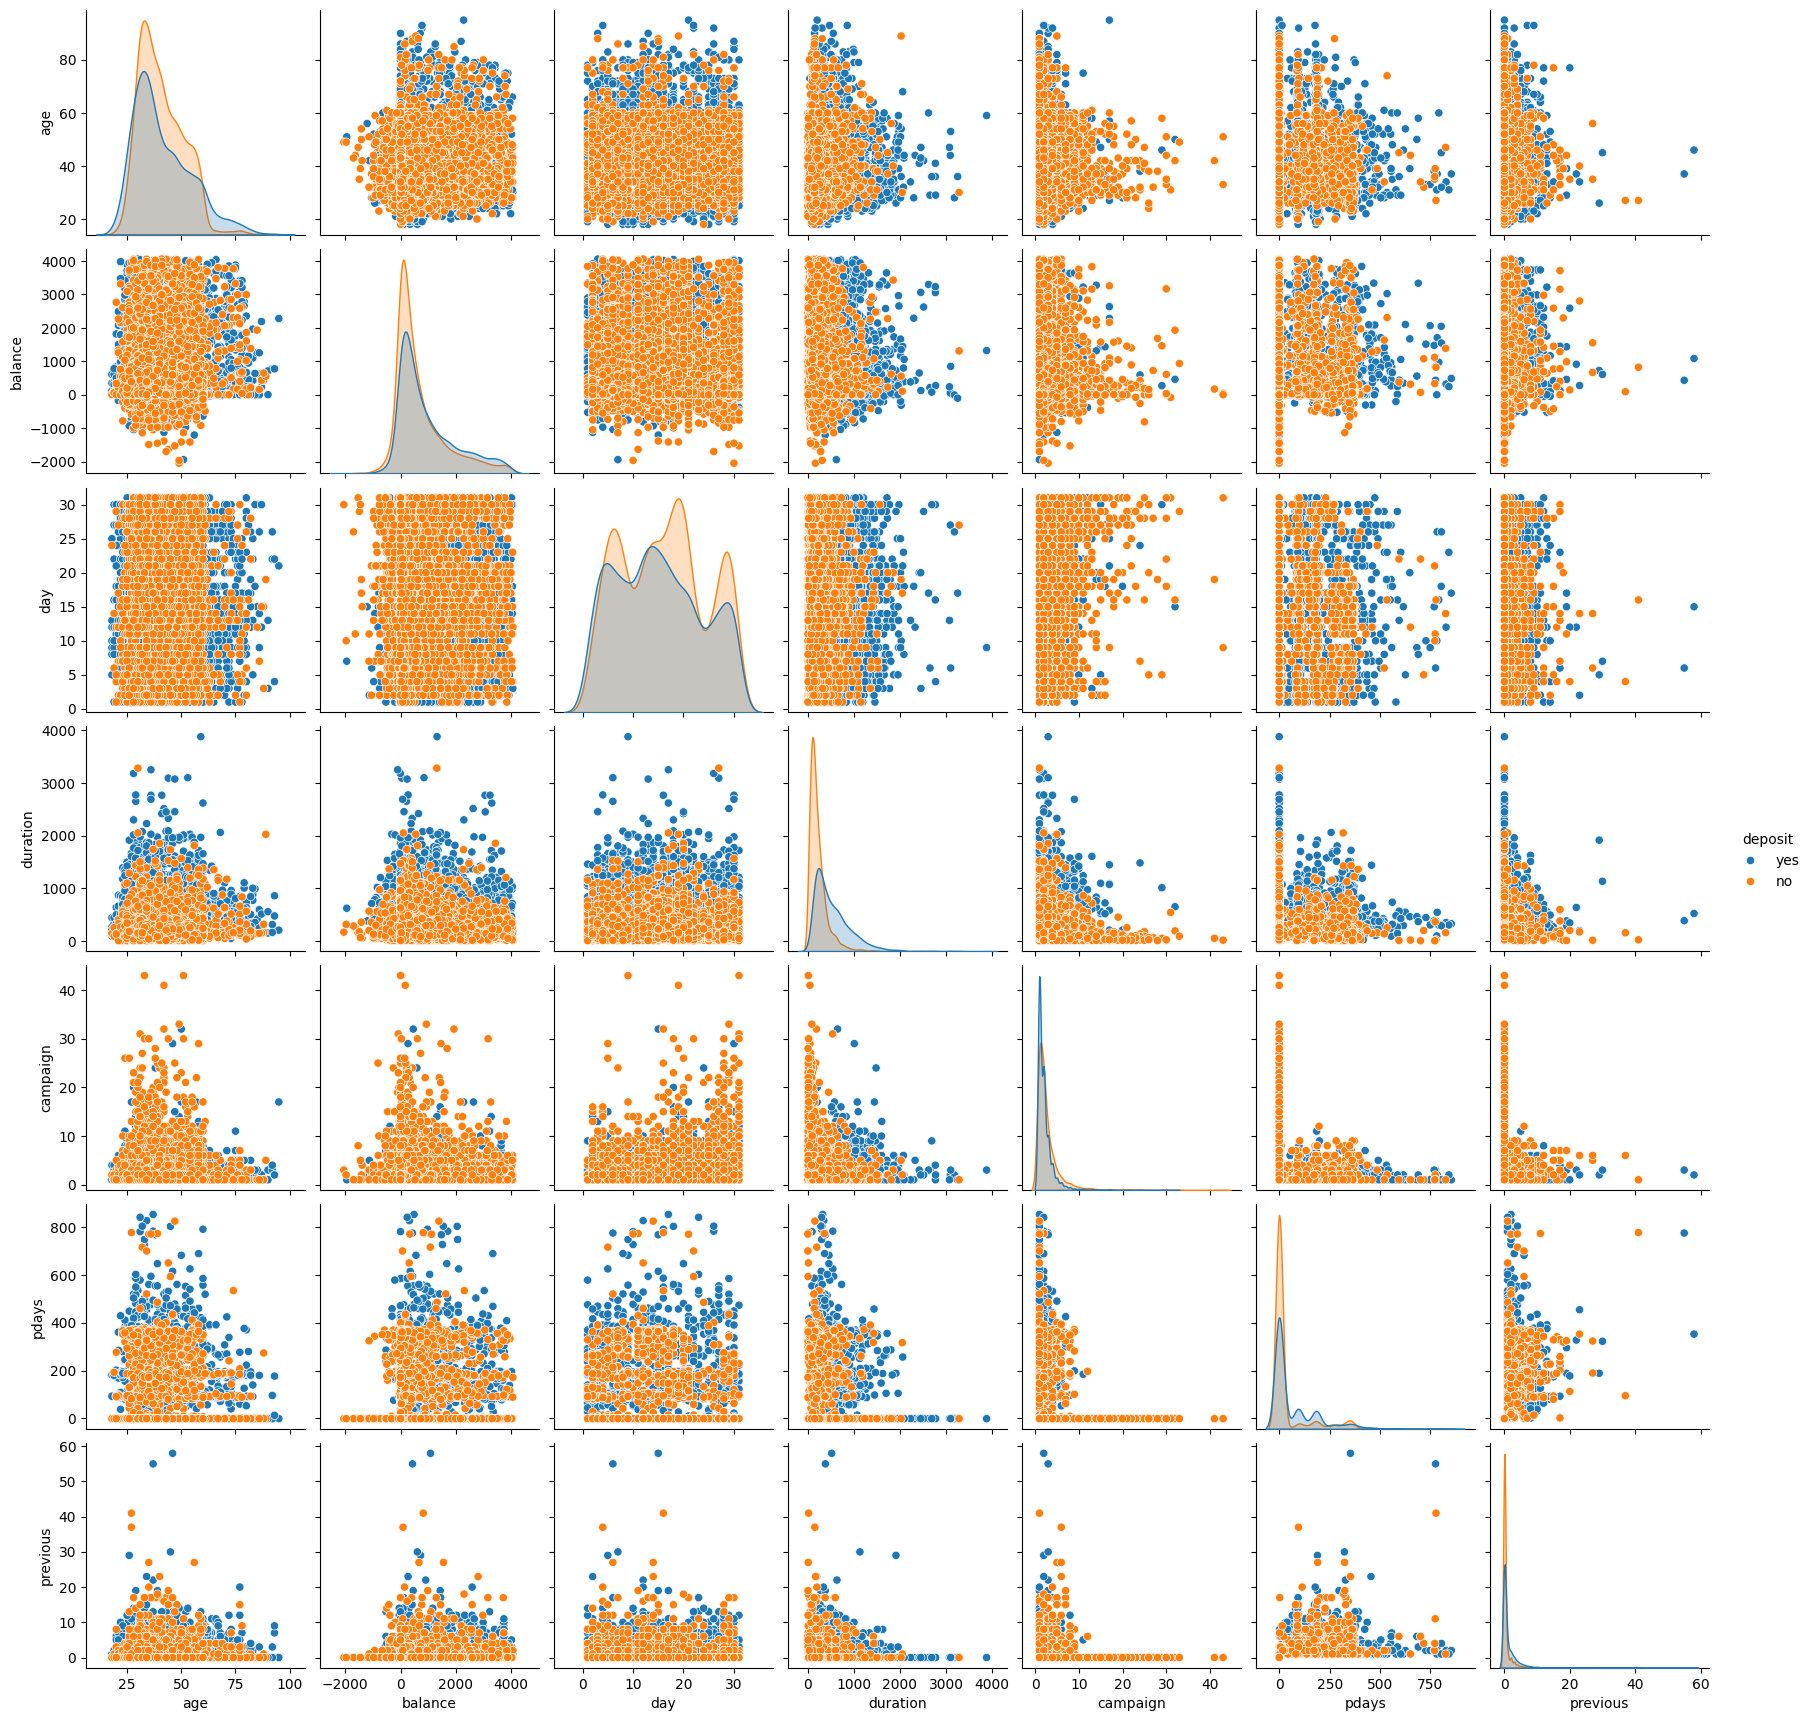

In [ ]:
# с помощью pairplot проилюстрируем взаимосвязи в признаках

sns.pairplot(data=cleaned,hue='deposit');

### Задания 2 и 3

In [13]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


**Выводы из графика pairplot и описательных статистик:**

* Признак `age` -  наличие выбросов в максимальных значениях, хотя отличие среднего от медианы всего два года<br>
* Признак `balance` - наличие выбросов в скорее в минимальных значениях судя по графику pairplot<br>
* Признак `day` - выбросы скорее отсутствуют, чем присутствуют <br>
* Признак `duration` -  наличие выбросов в максимальных значениях, с одним клиентом говорили более 1 часа<br>
* Признак `campaign` - наличие выбросов в максимальных значениях<br>
* Признак `pdays` - возможно наличие выбросов в максимальных значениях<br>
* Признак `previous` - наличие выбросов в максимальных значениях<br>

**Идеи:**
* Признаки `pdays`(количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании) и `previous`(количество контактов до текущей кампании) имеют одну общую черту - достаточное количество нулевых значений в обоих признаках. Для признака `pdays` это может означать что предыдущая компания еще иедет,закончилась вчера, клиент новый. Для признака `previous` что клиент новый раз до текущей компании с ним не было контактов. Возможно стоит вывести признак: `is_new_client` - является ли клиент новым.

* Признак `balance` - делит клиентов на формально на 3 группы: положительный, отрицательный, нулевой.
* * Возможно стоит исследовать взаимосвязь между отрицательным балансом наличием кредитов, конкретных кредитов на жилье, на личные нужды или просроченным кредитом. 
* * Выделить наличие отрицательного баланса при отстутствии кредитов.
* * Или бывает ли отрицательный баланс если нет просрочки по кредиту? 
* * Является ли отрицательный баланс обзязательным свидетельством наличия кредита?
* *  Также явно видно что при определенном возрасте клиентов отрицательный баланс отстутствует, возможно стоит вычислить этот возраст и разделить выборку по возрасту.

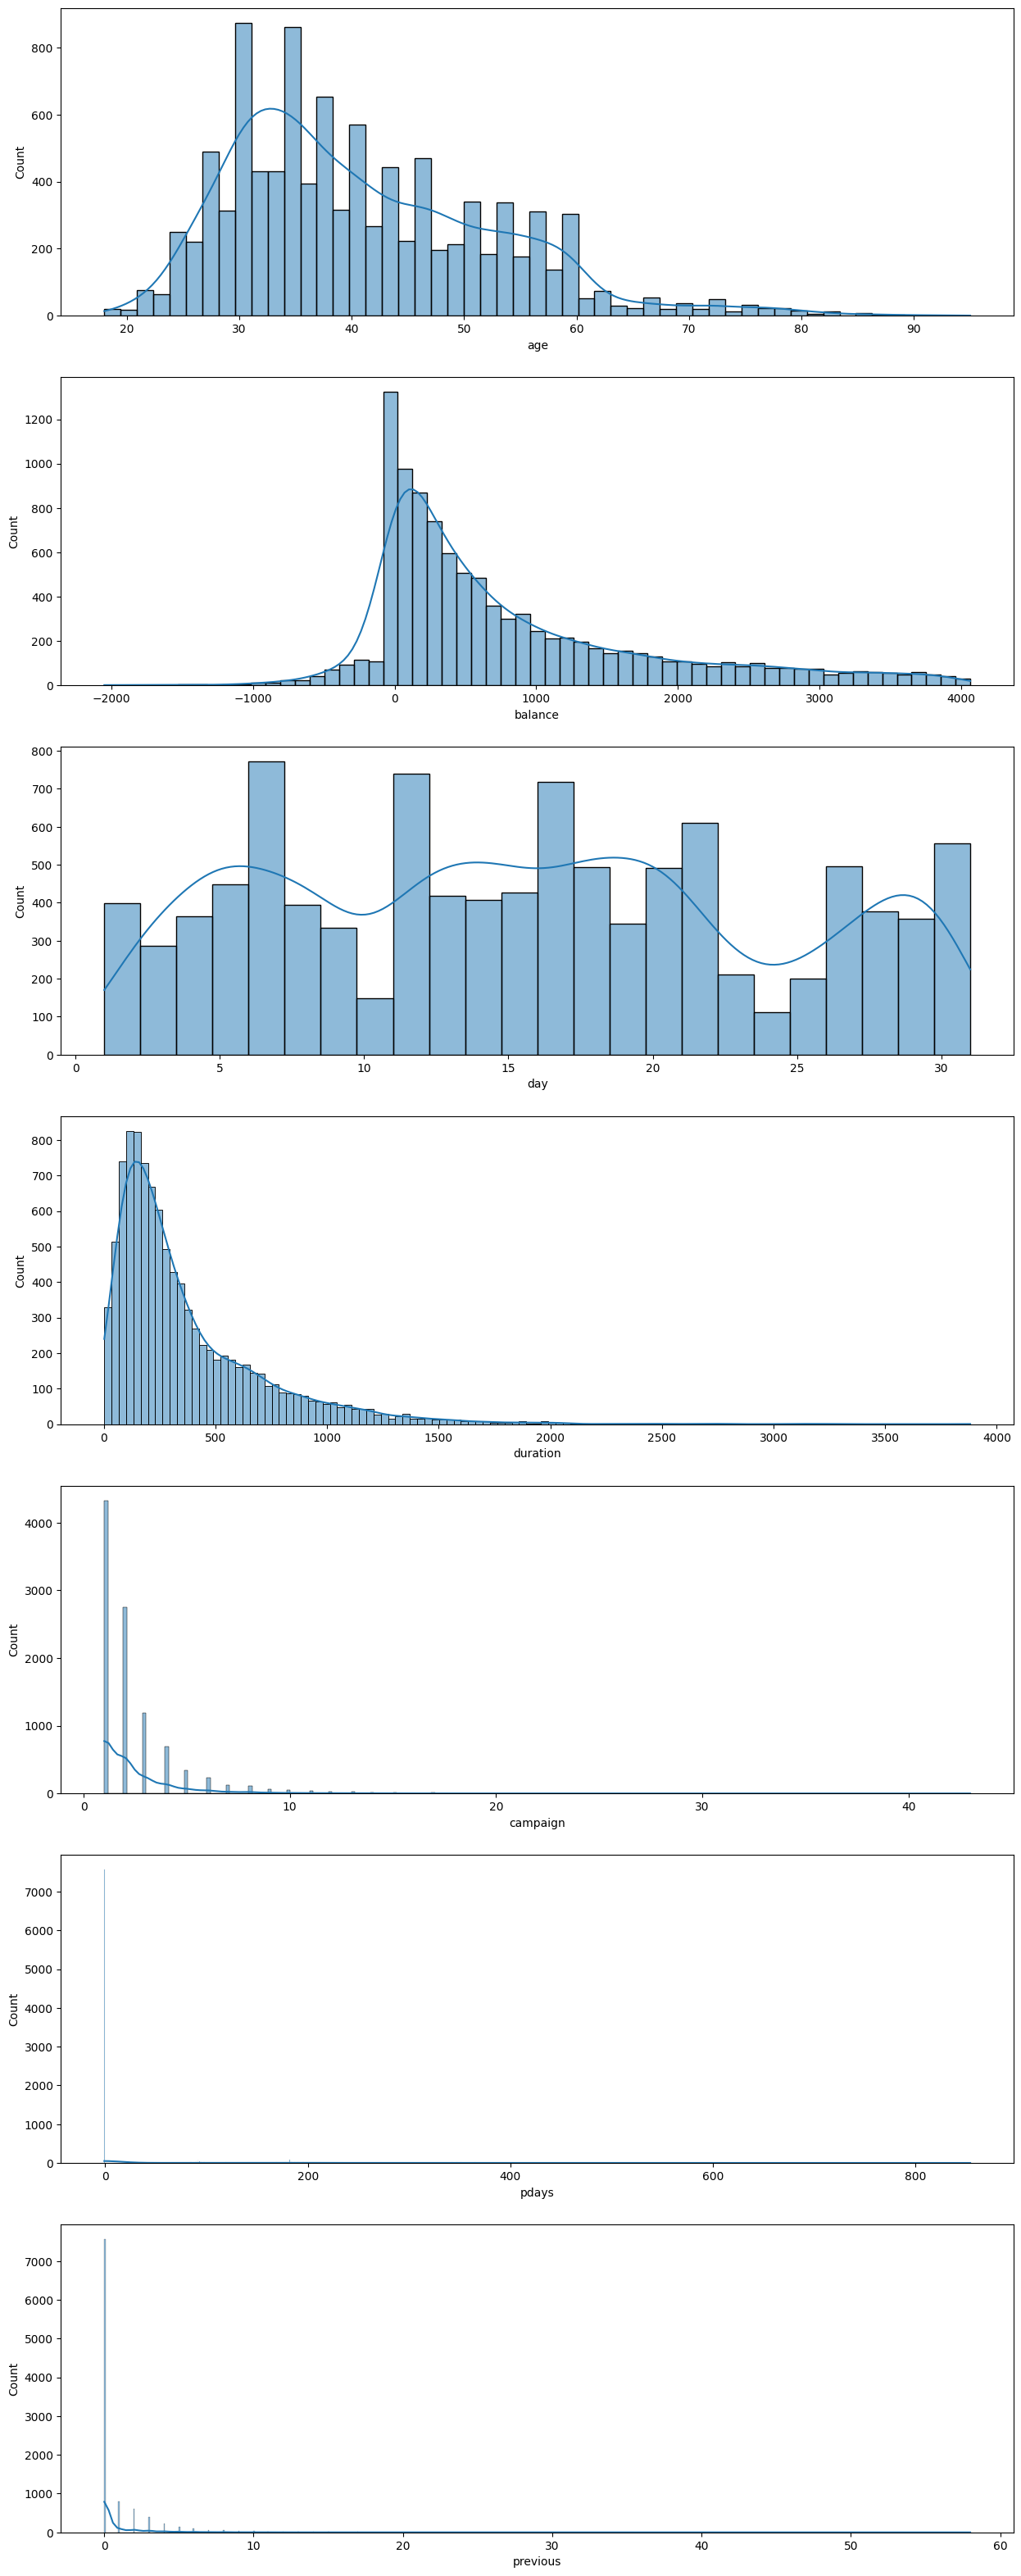

In [14]:
# проиллюстрируем распределения числовых признаков
numeric_features = cleaned.describe().columns.tolist()
n = len(numeric_features)
fig, axes = plt.subplots(nrows=n, ncols=1, figsize=(15, 40))
for i,feature in enumerate(numeric_features):
    sns.histplot(cleaned, x=feature, ax=axes[i], kde=True)
    


* Можно предположить что распределения `age`, `balance` признаков можно отнести к логнормальным (с натяжкой конечно же).
* Распределение признака `duration` можно отнести к логнормальному, а также что количество клиентов с отрицательным балансом меньше чем с положительным.

**Идеи**
* Можно попробовать создать признак положительного баланса `positive_balance`, но после создания стоит сличить его с признаками наличия кредитов, проверить на наличие мультиколлинеарности.

* Визуализация распределения признаков `pervious` и `pdays` дает понять что начилие нулевых значений существенно ухудшает наглядность графика, с одной стороны, но с другой стороны свидетельствует о том, что нулевых значений много.
* * Возможно стоит их отфильтровать, а если так то необходимо выяснить есть ли корреляция между этими двумя признаками и какая она.
* * Разделить выборку по нулевым значениям этих признаков и выяснить корреляцию по нулевым признакам. 

* Визуализация распределения признака `campaign` дает понять что большинство значений приходится на диапазон от 1 до 10. Следует выяснить долю и в зависимости от нее создать категориальный признак

### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


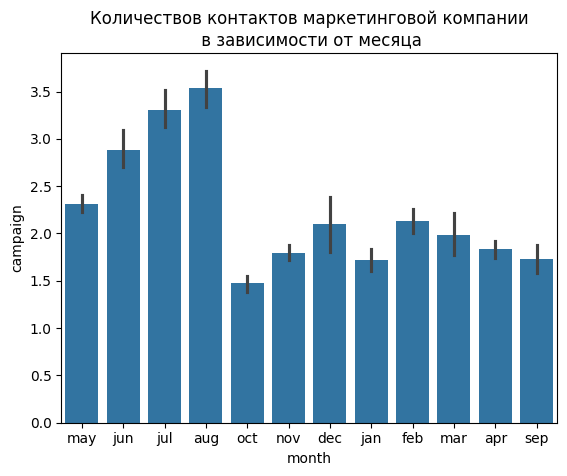

In [16]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
#постройте визуализации, иллюстрирующие результаты
display(cleaned.describe(include= 'object'))
campaign = sns.barplot(data=cleaned, x='month', y='campaign');
campaign.set_title('Количествов контактов маркетинговой компании\n в зависимости от месяца');

In [ ]:
# какие были результаты прошлой маркетинговой кампании
cleaned.poutcome.value_counts()

poutcome
unknown    7570
failure    1109
success     945
other       481
Name: count, dtype: int64

**Вопрос:**  означает ли значение `unknown` что прошлой маркетинговой компании не было? т.е. что этот клиент либо новый для взаимодействия с банком, т.е. она недавно стал клиентом банка и с ним еще не связывались.

### Задание 6

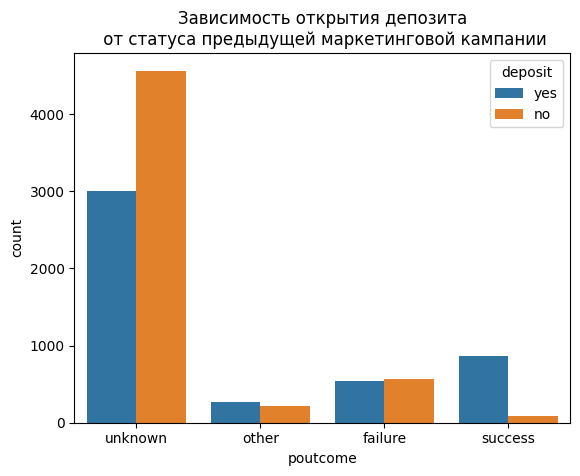

In [18]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
pout = sns.countplot(data=cleaned, x='poutcome', hue='deposit');
pout.set_title('Зависимость открытия депозита\n от статуса предыдущей маркетинговой кампании');


### Задание 7

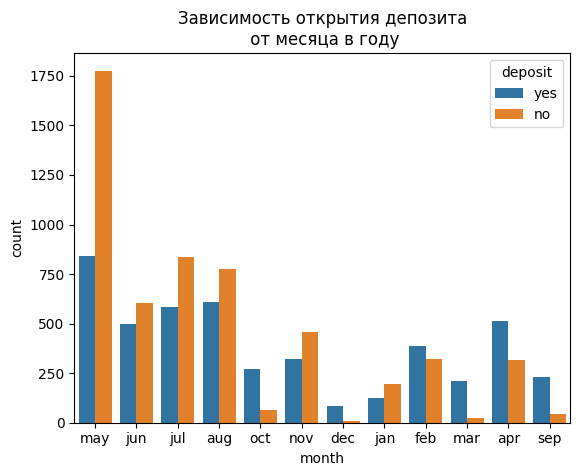

In [19]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код
month = sns.countplot(data=cleaned, x='month', hue='deposit');
month.set_title('Зависимость открытия депозита\n от месяца в году');

### Задание 8

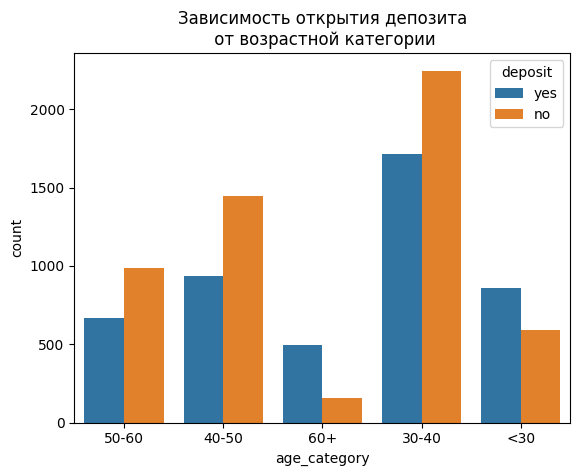

In [20]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
cleaned['age_category'] = cleaned['age'].apply(get_age_category)

age = sns.countplot(data=cleaned, x='age_category', hue='deposit');
age.set_title('Зависимость открытия депозита\n от возрастной категории');

### Задания 9 и 10

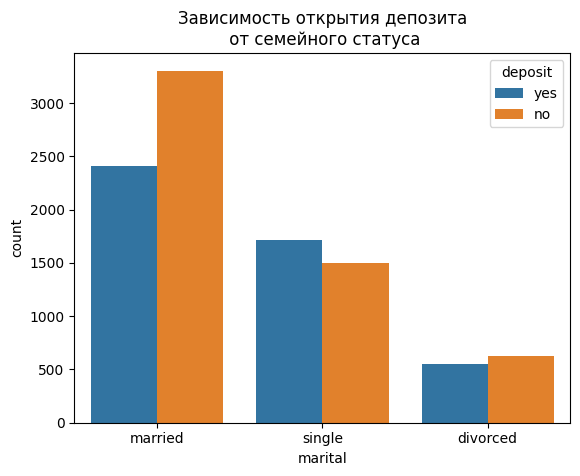

In [21]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
marital = sns.countplot(data=cleaned, x='marital', hue='deposit');
marital.set_title('Зависимость открытия депозита\n от семейного статуса');

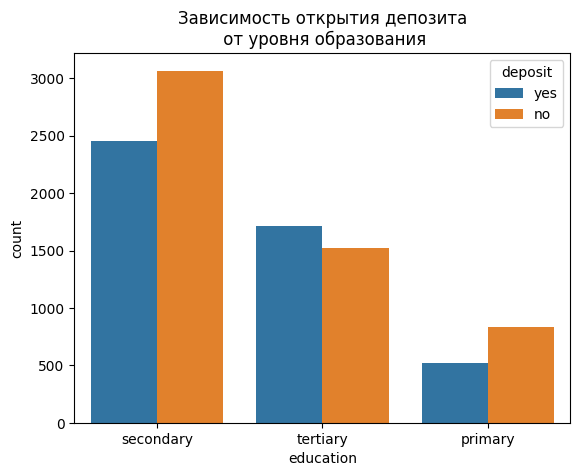

In [22]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
ed = sns.countplot(data=cleaned, x='education', hue='deposit');
ed.set_title('Зависимость открытия депозита\n от уровня образования');

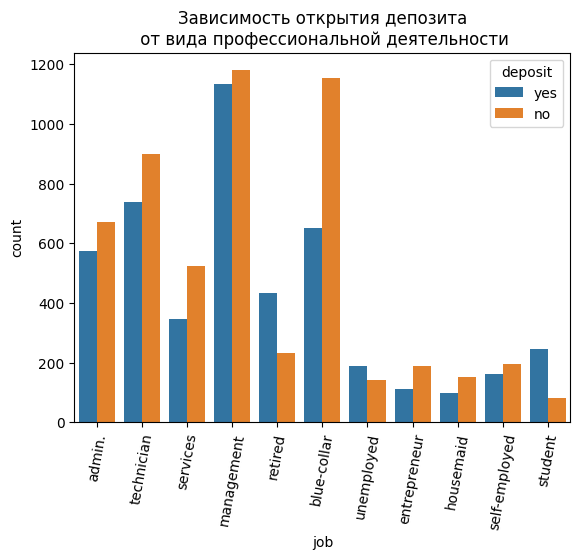

In [23]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
job = sns.countplot(data=cleaned, x='job', hue='deposit');
job.xaxis.set_tick_params(rotation=80)
job.set_title('Зависимость открытия депозита\n от вида профессиональной деятельности');

### Задание 11

marital,divorced,married,single
education,,,
primary,96,339,82
secondary,283,1289,879
tertiary,174,784,755


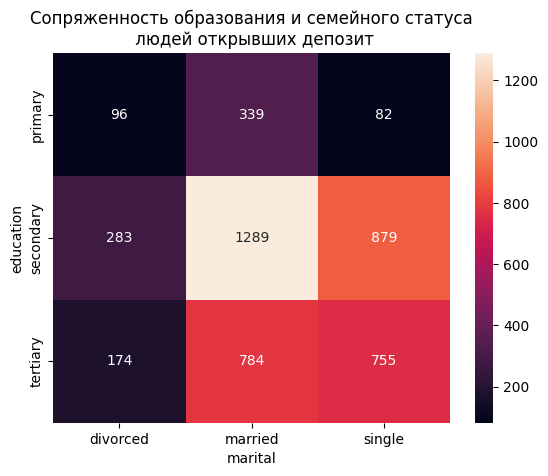

In [24]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

deposit_yes = cleaned[cleaned['deposit']=='yes']
cross_table = pd.crosstab(deposit_yes.education, deposit_yes.marital)
display(cross_table)
heat_cross = sns.heatmap(data=cross_table, annot=True, fmt= ".0f");
heat_cross.set_title('Сопряженность образования и семейного статуса\n людей открывших депозит');

## Часть 3: преобразование данных

### Задание 1

In [25]:
cleaned.education.value_counts()

education
secondary    5517
tertiary     3239
primary      1349
Name: count, dtype: int64

In [26]:
cleaned.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_category
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60


In [27]:
# преобразуйте уровни образования

#инициализируем кодировщик
encoder_le = LabelEncoder()

# трансформируем признак образования
cleaned.education = encoder_le.fit_transform(cleaned.education)

# проверяем значения
display(cleaned.education.value_counts())

# отвечаем на котнтрольный вопрос 
print('Сумма значений в закодированном признаке "education":{:.0f}'.format(cleaned.education.sum()))

# трансформируем признак категории возраста
cleaned.age_category = encoder_le.fit_transform(cleaned.age_category)
# проверяем значения
display(cleaned.age_category.value_counts())



education
1    5517
2    3239
0    1349
Name: count, dtype: int64

Сумма значений в закодированном признаке "education":11995


age_category
0    3961
1    2382
2    1654
4    1455
3     653
Name: count, dtype: int64

### Задания 2 и 3

In [28]:
# преобразуйте бинарные переменные в представление из нулей и единиц
for feature in cleaned.columns:
    if len(cleaned[feature].unique()) <=2:
        cleaned[feature] = cleaned[feature].apply(lambda x: 0 if x=='no'else 1)

print('Cтандартное отклонение в признаке "deposit":{:.3f}'.format(cleaned.deposit.std()))

Cтандартное отклонение в признаке "deposit":0.499


In [29]:
cols = ['loan','housing','default']
summ = []
for col in cleaned[cols]:
    summ.append(cleaned[col].mean())
print('Cумма средних признаков из списка cols:{:.3f}'.format(np.sum(summ)))

Cумма средних признаков из списка cols:0.635


### Задание 4

In [30]:
# создайте дамми-переменные

nominal_features = ['job', 'marital', 'contact', 'month', 'poutcome']

one_hot_encoder = OneHotEncoder()
 
# 'учим' и сразу применяем преобразование к выборке, результат переводим в массив
data_onehot = one_hot_encoder.fit_transform(cleaned[nominal_features]).toarray()
 
# запишем полученные названия новых колонок в отдельную переменную
column_names = one_hot_encoder.get_feature_names_out(nominal_features)
print(column_names)

# запишим дамми-переменные в отдельный датафрейм
onehot_df = pd.DataFrame(
    data=data_onehot,  # массив с закодированными данными
    index=cleaned.index,  # индексы из исходного датафрейма
    columns=column_names  # названия столбцов из кодировщика
)

# Объеденим с исходным датафреймом
data_full = pd.concat([cleaned,onehot_df], ignore_index=False, axis=1)

# удалим исходные столбцы
# data_cleaned = data_full.drop(columns=nominal_features, axis=1)

data_full.shape[1]-1


['job_admin.' 'job_blue-collar' 'job_entrepreneur' 'job_housemaid'
 'job_management' 'job_retired' 'job_self-employed' 'job_services'
 'job_student' 'job_technician' 'job_unemployed' 'marital_divorced'
 'marital_married' 'marital_single' 'contact_cellular' 'contact_telephone'
 'contact_unknown' 'month_apr' 'month_aug' 'month_dec' 'month_feb'
 'month_jan' 'month_jul' 'month_jun' 'month_mar' 'month_may' 'month_nov'
 'month_oct' 'month_sep' 'poutcome_failure' 'poutcome_other'
 'poutcome_success' 'poutcome_unknown']


50

In [31]:
# удалим исходные столбцы
data_cleaned = data_full.drop(columns=nominal_features, axis=1)

In [32]:
data_cleaned.housing.value_counts()

housing
0    5243
1    4862
Name: count, dtype: int64

### Задания 5 и 6

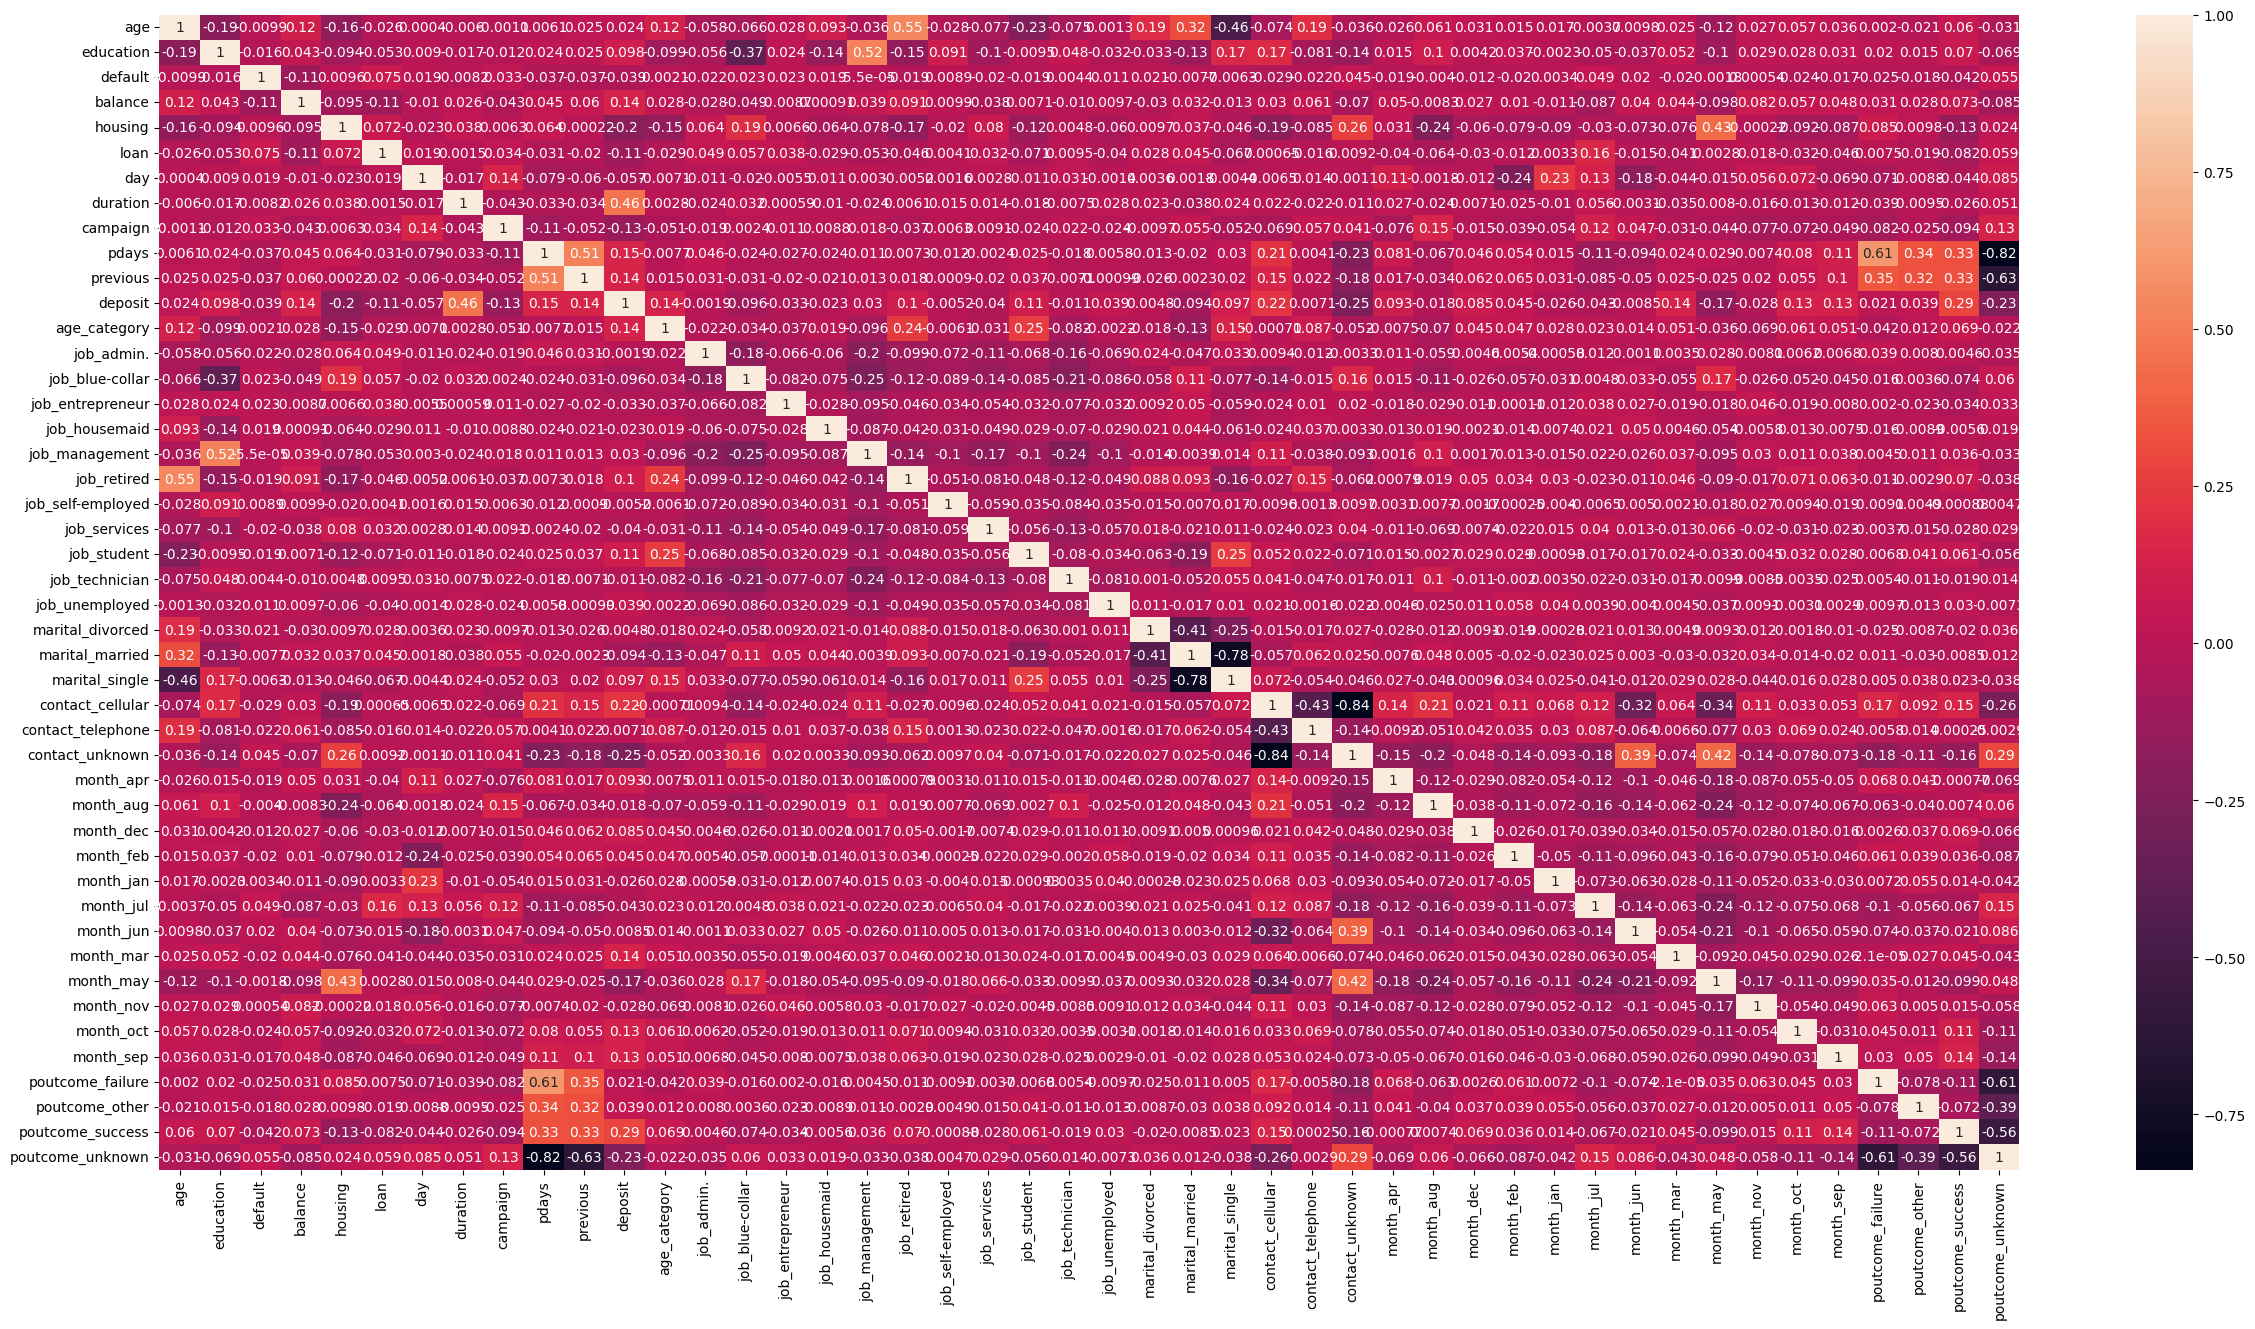

In [33]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(30,15))
sns.heatmap(data_cleaned.corr(numeric_only=True), annot = True);

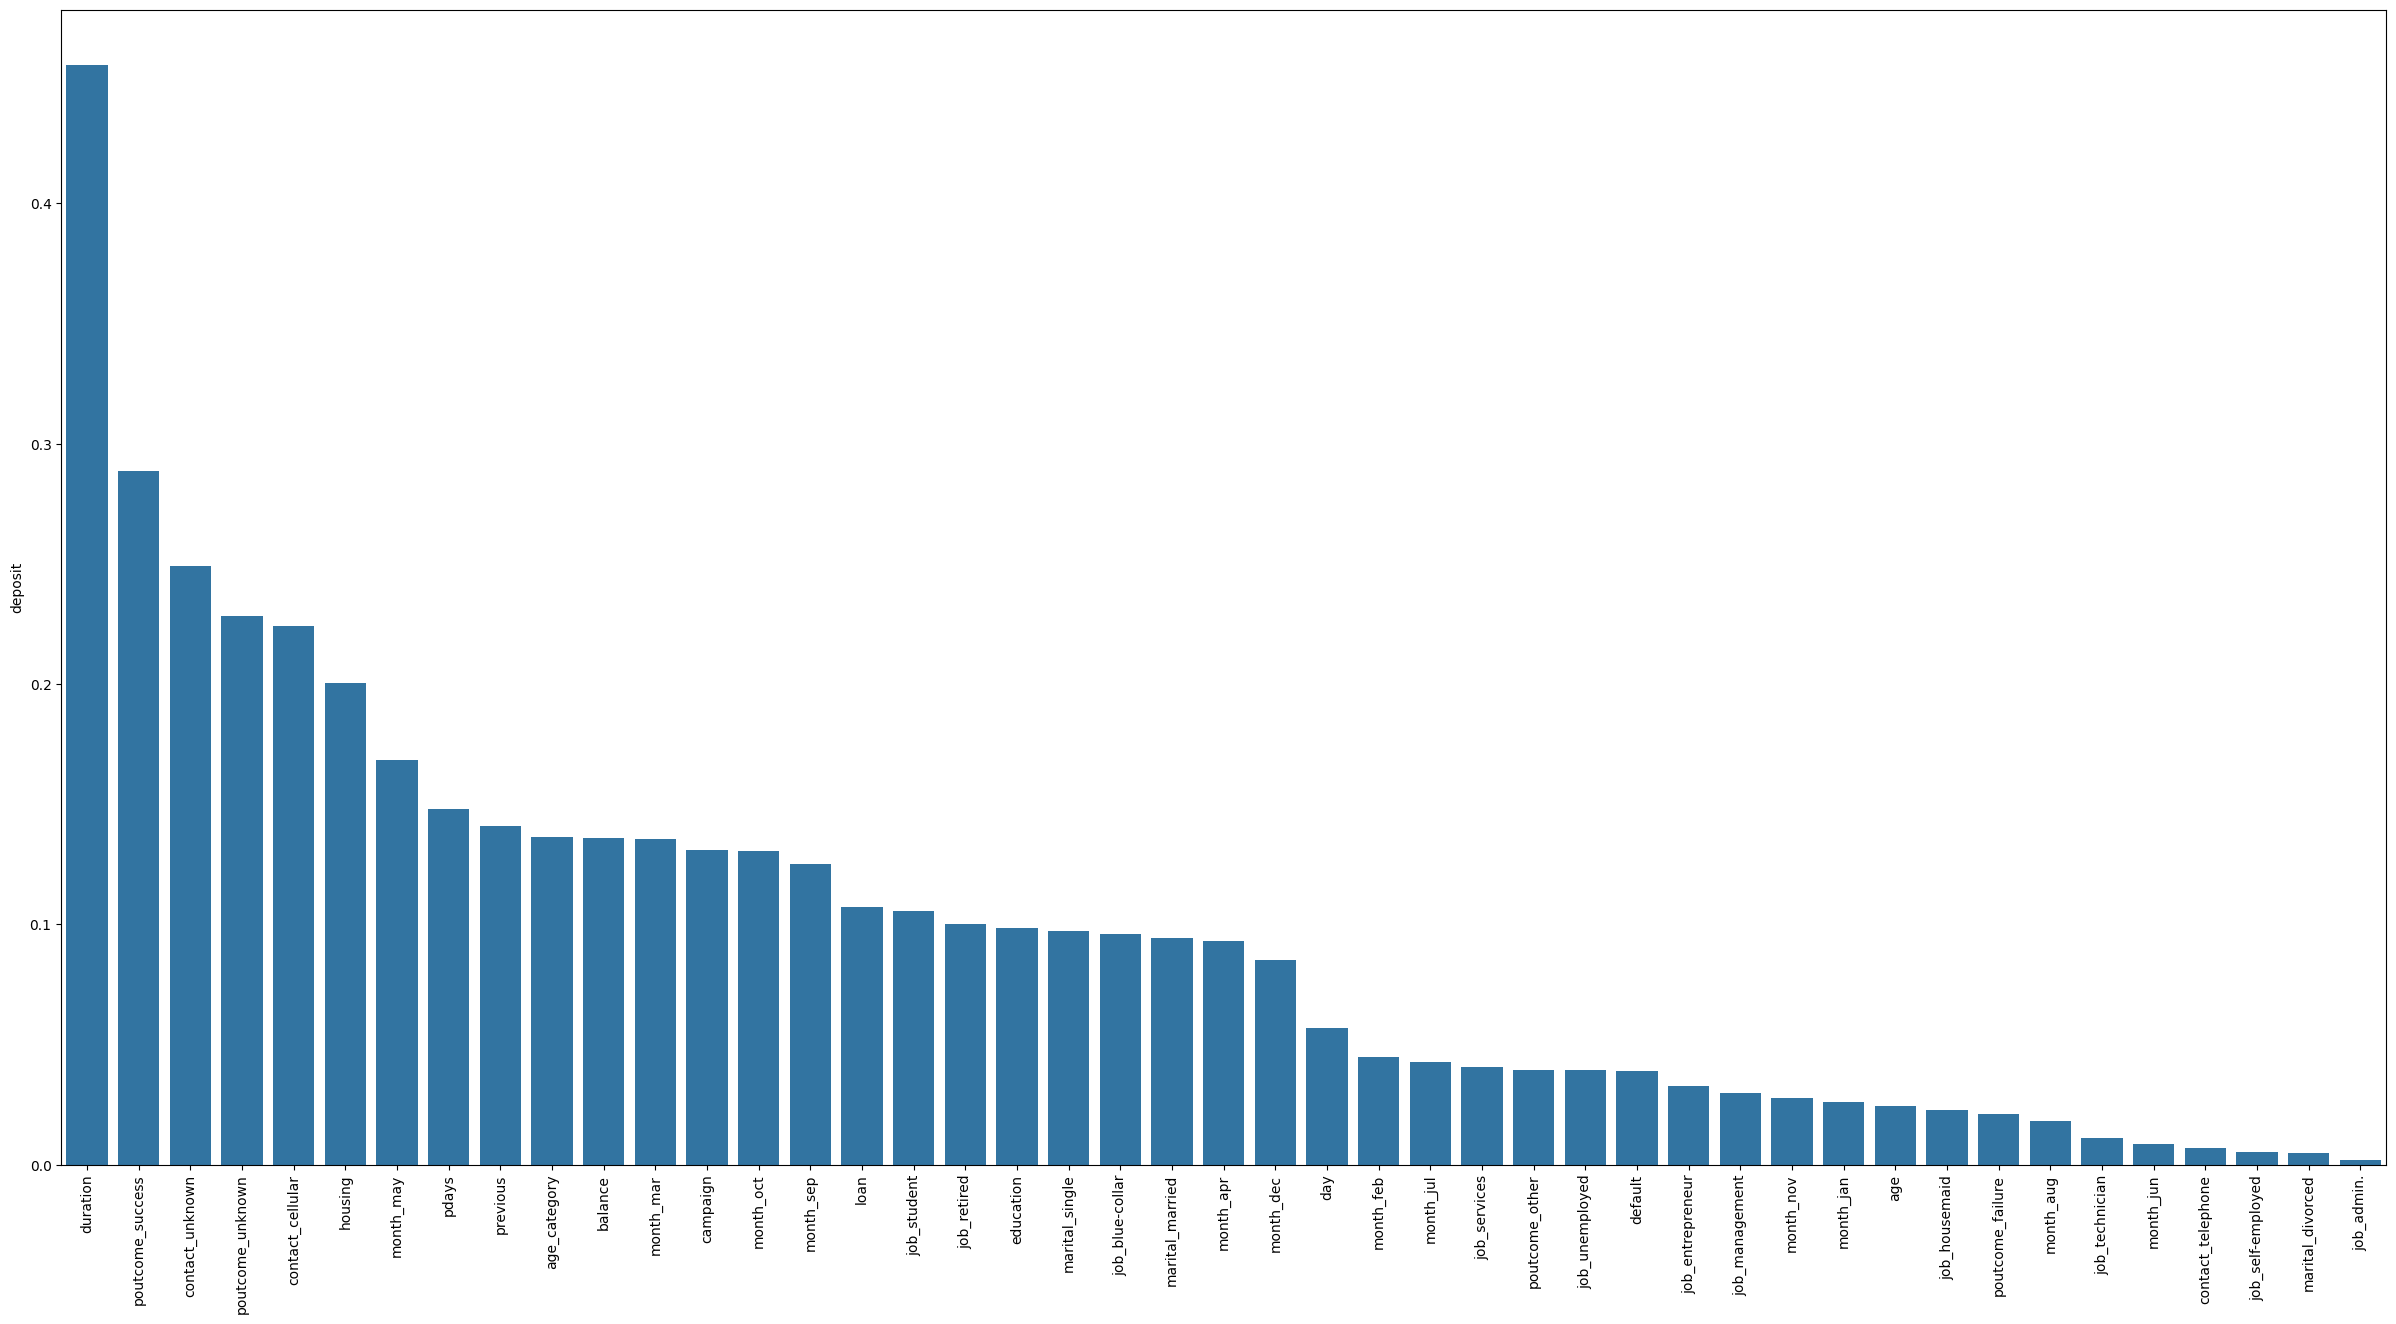

In [34]:
# Отсортируем признаки по абсолютной величине кореляции с целевым признаком
plt.figure(figsize=(30,15));
correliation = abs(data_cleaned.corr(numeric_only=True)['deposit']).sort_values(ascending=False).drop(labels='deposit')
sns.barplot(correliation);
plt.xticks(rotation=90);

### Задания 7 и 8

In [36]:
X = data_cleaned.drop(['deposit'], axis=1)
y = data_cleaned['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [37]:
# рассчитайте необходимые показатели
print('Размер тестовой выборки:{:.0f}'.format(y_test.shape[0]))
print('Cреднее значение целевой переменной на тестовой выборке:{:.2f}'.format(y_test.mean()))

Размер тестовой выборки:3335
Cреднее значение целевой переменной на тестовой выборке:0.46


### Задание 9

In [38]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_classif
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
best_cols = selector.get_feature_names_out().tolist()
display(best_cols)

# оставим 15 наиболее подходящих признаков
X_train_best = X_train[best_cols]
X_test_best = X_test[best_cols]

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_category',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

In [ ]:
# нормализуйте данные с помощью minmaxsxaler

# инициализируем скалер
scaler = MinMaxScaler()

# трансформируем предикторы
X_train_scaled = scaler.fit_transform(X_train_best)
X_test_scaled = scaler.transform(X_test_best)

# отвечаем на контрольный вопрос
print('Cреднее арифметическое для первого предиктора тестровой выборки:{:.2f}'.format(X_test_scaled.mean(axis=0)[0]))

Cреднее арифметическое для первого предиктора тестровой выборки:0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [40]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Создаем объект класса логистическая регрессия
reg = linear_model.LogisticRegression(
    solver= 'sag', #алгоритм оптимизации
    random_state=42, #генератор случайных чисел
    max_iter=1000 #количество итераций на сходимость
)
# Обучаем модель, минимизируя logloss
reg.fit(X_train_scaled, y_train)

# Делаем предсказание для тренировочной выборки
y_train_pred = reg.predict(X_train_scaled)
# Вывод  о метрике accuracy 
print('Train: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred)))

#Делаем предсказание для тестовой выборки
y_test_pred = reg.predict(X_test_scaled)
# Вывод  о метрике accuracy 
print('Test: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred)))


Train: 0.824
Test: 0.805


### Задания 2,3,4

In [41]:
# обучите решающие деревья, настройте максимальную глубину

#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    max_depth=6, #максимальная глубина
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений 
dt_clf.fit(X_train_scaled, y_train)

#Делаем предсказание класса для тренировочных данных
y_train_pred_dt = dt_clf.predict(X_train_scaled)

#Делаем предсказание класса для тестовых данных
y_test_pred_dt = dt_clf.predict(X_test_scaled)

print('Глубина дерева: {:.0f}'.format(dt_clf.get_depth()))
print()
#Выводим отчёт о метриках классификации
print('Train: {:.3f}'.format(metrics.accuracy_score(y_train, y_train_pred_dt)))
print('Test: {:.3f}'.format(metrics.accuracy_score(y_test, y_test_pred_dt)))

Глубина дерева: 6

Train: 0.818
Test: 0.809


### Задание 5

In [42]:
# подберите оптимальные параметры с помощью gridsearch

from sklearn.model_selection import GridSearchCV

param_grid = [
              {'min_samples_split': [2, 5, 7, 10],
               'max_depth':[3,5,7] } # словарь параметров
             ]

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
      criterion='entropy', #критерий информативности 
      random_state=42 #генератор случайных чисел
    ), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

CPU times: user 372 ms, sys: 182 ms, total: 554 ms
Wall time: 6.34 s
accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.81
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [43]:
# обучите на ваших данных случайный лес
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)

#Выводим значения метрики 
y_test_pred = rf.predict(X_test_scaled)
print((metrics.classification_report(y_test, y_test_pred)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [61]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    min_samples_leaf = 5, #число объектов в листе
    max_depth=5, #максимальная глубина дерева
    random_state=42 #генератор случайных чисел
)
# Обучаем модель
gb.fit(X_train_scaled, y_train)
# Формируем предсказание для тестовой выборки
y_pred = gb.predict(X_test_scaled)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [53]:
# объедините уже известные вам алгоритмы с помощью стекинга 

# Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('rf', rf),
    ('gb',  gb)
]

# Создаем объект класса стекинг
stack = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression()
)
# Обучаем модель
stack.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
y_pred = stack.predict(X_test_scaled)
# Посмотрим на основные метрики классификации
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1790
           1       0.81      0.82      0.81      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 5

In [71]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
estimator  = GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=3, step=1)
X_train_scaled_df = pd.DataFrame(data=X_train_scaled, columns=best_cols)
selector = selector.fit(X_train_scaled_df, y_train)
 
selector.get_feature_names_out()

array(['duration', 'contact_unknown', 'poutcome_success'], dtype=object)

### Задания 6,7,8

In [76]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
random_state = 42

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = RandomForestClassifier(n_estimators=n_estimators,
                                 max_depth=max_depth,
                                 min_samples_leaf=min_samples_leaf,
                                 random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

In [77]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2024-12-25 16:48:01,385] A new study created in memory with name: RandomForestClassifier
[I 2024-12-25 16:48:05,417] Trial 0 finished with value: 0.8779650436953808 and parameters: {'n_estimators': 115, 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8779650436953808.
[I 2024-12-25 16:48:08,894] Trial 1 finished with value: 0.8562441019188424 and parameters: {'n_estimators': 117, 'max_depth': 11, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8779650436953808.
[I 2024-12-25 16:48:12,881] Trial 2 finished with value: 0.8486367909746161 and parameters: {'n_estimators': 116, 'max_depth': 16, 'min_samples_leaf': 9}. Best is trial 0 with value: 0.8779650436953808.
[I 2024-12-25 16:48:16,702] Trial 3 finished with value: 0.8450039339103068 and parameters: {'n_estimators': 150, 'max_depth': 10, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8779650436953808.
[I 2024-12-25 16:48:20,178] Trial 4 finished with value: 0.859871614216377 and parameters: {'n_e

CPU times: user 52.7 s, sys: 919 ms, total: 53.7 s
Wall time: 1min 20s


In [78]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 100, 'max_depth': 29, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [89]:
# рассчитаем точность для тестовой выборки
model = RandomForestClassifier(**study.best_params,random_state=random_state)
model.fit(X_train_scaled, y_train)

print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.82


In [84]:
%%time
# продолжим подбор 
study.optimize(optuna_rf, n_trials=20)

[I 2024-12-25 16:58:10,372] Trial 60 finished with value: 0.9244987468671679 and parameters: {'n_estimators': 148, 'max_depth': 27, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.9253216190775023.
[I 2024-12-25 16:58:16,210] Trial 61 finished with value: 0.925125313283208 and parameters: {'n_estimators': 150, 'max_depth': 27, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.9253216190775023.
[I 2024-12-25 16:58:20,223] Trial 62 finished with value: 0.9238483234095894 and parameters: {'n_estimators': 150, 'max_depth': 26, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.9253216190775023.
[I 2024-12-25 16:58:26,186] Trial 63 finished with value: 0.9252702490991697 and parameters: {'n_estimators': 159, 'max_depth': 27, 'min_samples_leaf': 2}. Best is trial 22 with value: 0.9253216190775023.
[I 2024-12-25 16:58:30,652] Trial 64 finished with value: 0.8942097026604069 and parameters: {'n_estimators': 163, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 22 with val

CPU times: user 1min 8s, sys: 438 ms, total: 1min 8s
Wall time: 1min 31s


In [86]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 193, 'max_depth': 25, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.93


In [88]:
# рассчитаем метрики для тестовой выборки
model = RandomForestClassifier(**study.best_params,random_state=random_state)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

accuracy на тестовом наборе: 0.82
f1_score на тестовом наборе: 0.82


# Выводы:

1. Максмимальное значение метрики F1 которого удалось добиться 0.82.
2. Усложнение моделей по сравнению с базовыми не дало значимого улучшения результата.
3. Подбор гиперпараметров дал минимальное увеличение метрики.
    * Возможен дальнейший подбор гиперпараметров путем уточнения пространства гиперпараметров
4. Для дальнейшего исследования возможно проработка идей изложенных в работе:
    * Альтернативная обработка пропусков и признаков
    * Генерация дополнительных признаков  